In [86]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 9)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

ModuleNotFoundError: No module named 'nbinteract'

In [87]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [88]:
# HIDDEN
def plot_loss(y_vals, xlim, loss_fn):
    thetas = np.arange(xlim[0], xlim[1] + 0.01, 0.05)
    losses = [loss_fn(theta, y_vals) for theta in thetas]
    
    plt.figure(figsize=(5, 3))
    plt.plot(thetas, losses, zorder=1)
    plt.xlim(*xlim)
    plt.title(loss_fn.__name__)
    plt.xlabel(r'$ \theta $')
    plt.ylabel('Loss')
    
def plot_theta_on_loss(y_vals, theta, loss_fn, **kwargs):
    loss = loss_fn(theta, y_vals)
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c=sns.xkcd_rgb['green'])
    plt.scatter([theta], [loss], **{**default_args, **kwargs})

def plot_tangent_on_loss(y_vals, theta, loss_fn, eps=1e-6):
    slope = ((loss_fn(theta + eps, y_vals) - loss_fn(theta - eps, y_vals))
             / (2 * eps))
    xs = np.arange(theta - 1, theta + 1, 0.05)
    ys = loss_fn(theta, y_vals) + slope * (xs - theta)
    plt.plot(xs, ys, zorder=3, c=sns.xkcd_rgb['green'], linestyle='--')

## Batch Gradient Descent

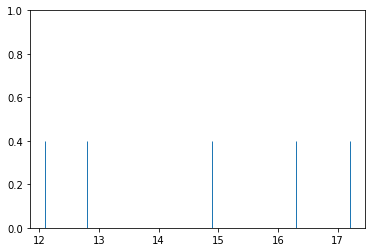

In [89]:
pts = np.array([12.1, 12.8, 14.9, 16.3, 17.2])
sns.rugplot(pts, height=0.4)

In [90]:
def mse(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

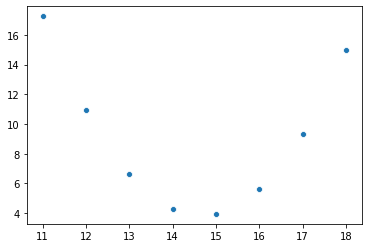

In [91]:
thetas = np.arange(11, 19, 1)
mses = [mse(theta, pts) for theta in thetas]
sns.scatterplot(thetas, mses);

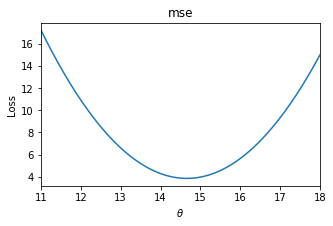

In [92]:
plot_loss(pts, (11, 18), mse)

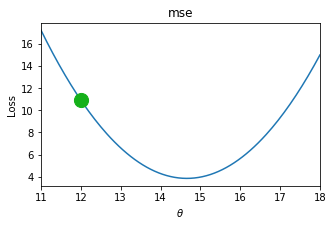

In [93]:
start = 12
plot_loss(pts, (11, 18), mse)
plot_theta_on_loss(pts, start, mse)

In [94]:
def grad_mse(theta, y_vals):
    return -2 * np.mean(y_vals - theta)

In [95]:
def grad_descent_one(theta, y_vals, grad_loss, alpha=0.3):
    return theta - alpha * grad_loss(theta, y_vals)

In [96]:
start = 12
grad_descent_one(start, pts, grad_mse)

13.596

In [97]:
def plot_one_gd_iter(y_vals, theta, loss_fn, grad_loss, alpha=0.3):
    new_theta = grad_descent_one(theta, y_vals, grad_loss, alpha)
    plot_loss(pts, (11, 18), loss_fn)
    plot_theta_on_loss(pts, theta, loss_fn, c='none',
                       edgecolor=sns.xkcd_rgb['green'], linewidth=2)
    plot_theta_on_loss(pts, new_theta, loss_fn)
    print(f'old theta: {theta}')
    print(f'new theta: {new_theta}')

old theta: 12
new theta: 13.596


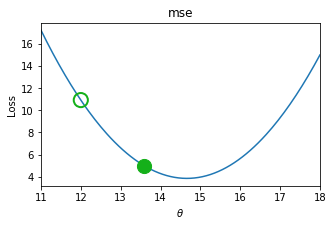

In [98]:
plot_one_gd_iter(pts, start, mse, grad_mse)

old theta: 13.6
new theta: 14.236


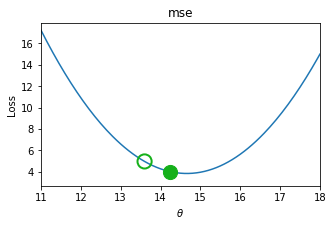

In [99]:
plot_one_gd_iter(pts, 13.6, mse, grad_mse)

old theta: 14.5
new theta: 14.596


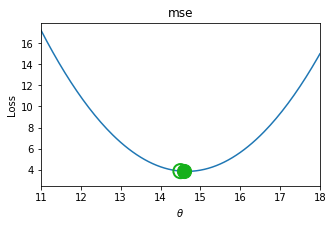

In [100]:
plot_one_gd_iter(pts, 14.5, mse, grad_mse)

In [101]:
np.mean(pts)

14.66

## Adjusting the Learning Rate

In [102]:
def plot_n_gd_iter(n, y_vals, theta, loss_fn, grad_loss, alpha=0.3):
    for _ in range(n):
        new_theta = grad_descent_one(theta, y_vals, grad_loss, alpha)
        plot_loss(pts, (11, 18), loss_fn)
        plot_theta_on_loss(pts, theta, loss_fn, c='none',
                           edgecolor=sns.xkcd_rgb['green'], linewidth=2)
        plot_theta_on_loss(pts, new_theta, loss_fn)
        theta = new_theta
        plt.show()

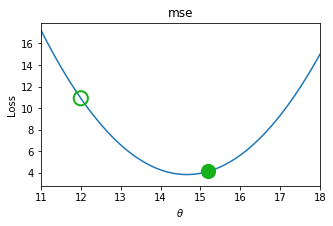

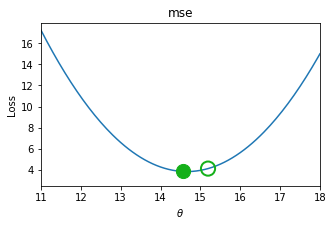

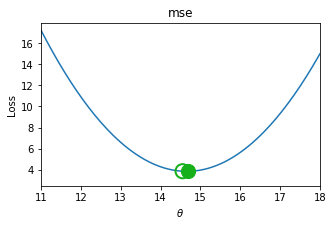

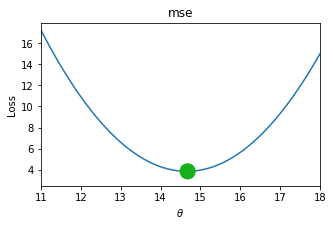

In [103]:
alpha = 0.6
plot_n_gd_iter(4, pts, start, mse, grad_mse, alpha)

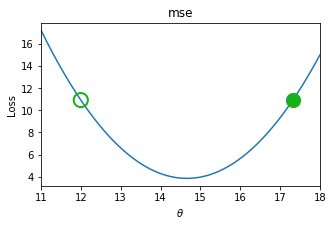

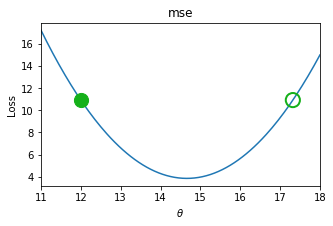

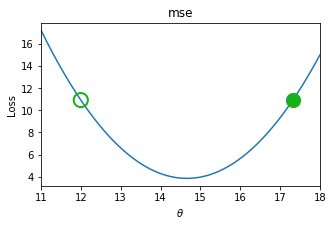

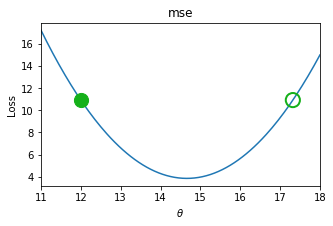

In [104]:
alpha = 1
plot_n_gd_iter(4, pts, start, mse, grad_mse, alpha)

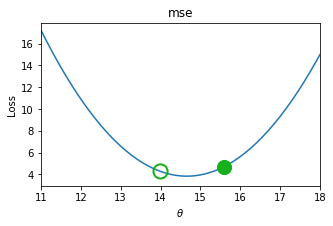

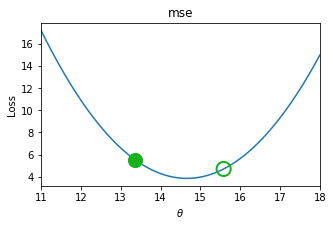

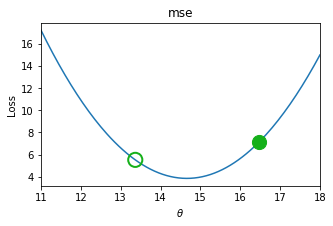

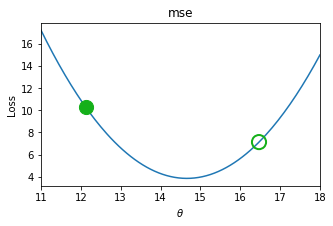

In [105]:
alpha = 1.2
plot_n_gd_iter(4, pts, 14, mse, grad_mse, alpha)

## Fitting a Linear Model

In [106]:
from scipy.optimize import minimize as sci_min
def minimize(loss_fn, grad_loss_fn, X, y, progress=True):
    '''
    Uses scipy.minimize to minimize loss_fn using a form of gradient descent.
    '''
    theta = np.zeros(X.shape[1])
    iters = 0
    
    def objective(theta):
        return loss_fn(theta, X, y)
    def gradient(theta):
        return grad_loss_fn(theta, X, y)
    def print_theta(theta):
        nonlocal iters
        if progress:
            print(f'theta: {theta} | loss: {loss_fn(theta, X, y):.2f}')
        iters += 1

    return sci_min(
        objective, theta, method='BFGS', jac=gradient, callback=print_theta,
        tol=1e-7
    ).x

In [107]:
mpg = sns.load_dataset('mpg').dropna()
mpg

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino
5,15.0,8,429.0,198.0,4341,10.0,70,usa,ford galaxie 500
6,14.0,8,454.0,220.0,4354,9.0,70,usa,chevrolet impala
7,14.0,8,440.0,215.0,4312,8.5,70,usa,plymouth fury iii
8,14.0,8,455.0,225.0,4425,10.0,70,usa,pontiac catalina
9,15.0,8,390.0,190.0,3850,8.5,70,usa,amc ambassador dpl


In [108]:
cols = ['bias','cylinders','displacement','horsepower','weight','acceleration',
       'model_year']
X=mpg.assign(bias=1)[cols].values
y=mpg['mpg'].values

In [109]:
X

array([[1.000e+00, 8.000e+00, 3.070e+02, ..., 3.504e+03, 1.200e+01,
        7.000e+01],
       [1.000e+00, 8.000e+00, 3.500e+02, ..., 3.693e+03, 1.150e+01,
        7.000e+01],
       [1.000e+00, 8.000e+00, 3.180e+02, ..., 3.436e+03, 1.100e+01,
        7.000e+01],
       ...,
       [1.000e+00, 4.000e+00, 1.350e+02, ..., 2.295e+03, 1.160e+01,
        8.200e+01],
       [1.000e+00, 4.000e+00, 1.200e+02, ..., 2.625e+03, 1.860e+01,
        8.200e+01],
       [1.000e+00, 4.000e+00, 1.190e+02, ..., 2.720e+03, 1.940e+01,
        8.200e+01]])

In [110]:
X.shape

(392, 7)

In [111]:
y

array([18. , 15. , 18. , 16. , 17. , 15. , 14. , 14. , 14. , 15. , 15. ,
       14. , 15. , 14. , 24. , 22. , 18. , 21. , 27. , 26. , 25. , 24. ,
       25. , 26. , 21. , 10. , 10. , 11. ,  9. , 27. , 28. , 25. , 19. ,
       16. , 17. , 19. , 18. , 14. , 14. , 14. , 14. , 12. , 13. , 13. ,
       18. , 22. , 19. , 18. , 23. , 28. , 30. , 30. , 31. , 35. , 27. ,
       26. , 24. , 25. , 23. , 20. , 21. , 13. , 14. , 15. , 14. , 17. ,
       11. , 13. , 12. , 13. , 19. , 15. , 13. , 13. , 14. , 18. , 22. ,
       21. , 26. , 22. , 28. , 23. , 28. , 27. , 13. , 14. , 13. , 14. ,
       15. , 12. , 13. , 13. , 14. , 13. , 12. , 13. , 18. , 16. , 18. ,
       18. , 23. , 26. , 11. , 12. , 13. , 12. , 18. , 20. , 21. , 22. ,
       18. , 19. , 21. , 26. , 15. , 16. , 29. , 24. , 20. , 19. , 15. ,
       24. , 20. , 11. , 20. , 19. , 15. , 31. , 26. , 32. , 25. , 16. ,
       16. , 18. , 16. , 13. , 14. , 14. , 14. , 29. , 26. , 26. , 31. ,
       32. , 28. , 24. , 26. , 24. , 26. , 31. , 19

In [112]:
y.shape

(392,)

1. Create a `linear model` function which return predictions on x_vals. <br>Use vector multipication to make it.

In [113]:
def linear_model(thetas, X):
    return X @ thetas

2. Create a `mse loss`function whcih return mse loss with thetas, X and y

In [114]:
def mse_loss(thetas, X, y):
    return np.mean((y - linear_model(thetas, X) ** 2))

3. Create a `grad_mse_loss` function which computes the gradient of mse loss function w.r.t theta. <br>This step is prepared for the update rule.<br>


In [115]:
def grad_mse_loss(thetas, X, y):
    n = len(X)
    return -2/n * (X.T @ y - X.T @ X @ thetas)

4. Once we have all these three pieces done, the `linear_model`, `mse_loss`function, and `gradient of mse loss`function, we can **fit our model** by calling minimizing function, a function that minimizes loss_fn using a form of gradient descent.


In [117]:
minimize(mse_loss, grad_mse_loss,X,y)

theta: [2.43013282e-06 1.22272106e-05 4.04463149e-04 2.29697314e-04
 6.66550981e-03 3.87098863e-05 1.86366132e-04] | loss: -407.64
theta: [ 1.04900214e-03  1.44337411e-05 -1.60422748e-01 -1.75185340e-02
  1.62656539e-02  2.10107257e-02  8.66594815e-02] | loss: -521.44
theta: [ 0.00588689  0.01203752 -0.04335732  0.11595489 -0.00626987  0.09085103
  0.4856839 ] | loss: -569.90
theta: [ 0.00658403  0.01424245  0.00410693 -0.00839227 -0.0070189   0.11211543
  0.56097119] | loss: -574.97
theta: [-0.001346   -0.0337142   0.00280898 -0.02140275 -0.00644447 -0.06780214
  0.59996464] | loss: -575.09
theta: [-0.04574654 -0.32691325  0.00725357 -0.02103079 -0.00641525 -0.05803296
  0.6066247 ] | loss: -575.11
theta: [-0.11585186 -0.53128539  0.01035267 -0.02071575 -0.00639592 -0.05083641
  0.61166344] | loss: -575.16
theta: [-0.34457202 -0.5918106   0.01127593 -0.02032627 -0.00639564 -0.04664971
  0.61526088] | loss: -575.18
theta: [-1.53860781 -0.71538335  0.01318    -0.01849557 -0.00641412 -0.

array([-1.41940429e+01, -5.75009882e-01,  1.13847339e-02, -6.19179462e-04,
       -6.76027540e-03,  8.97021066e-02,  7.55105896e-01])

From the output above, we can see that it keeps updating the theta until the loss doesn't change anymore and return the corresponding theta array.

Here we compare the gradient descent update method with the matrix inverse solution.

In [118]:
def fit_linear(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y
fit_linear(X, y)

array([-1.45352505e+01, -3.29859089e-01,  7.67843024e-03, -3.91355574e-04,
       -6.79461791e-03,  8.52732469e-02,  7.53367180e-01])

We can see they have almost the same result.

Let's **take a peak inside GD.**

In [119]:
cols = ['bias','horsepower']
X = mpg.assign(bias=1)[cols].values
y = mpg['mpg'].values

In [120]:
thetas = minimize(mse_loss, grad_mse_loss, X, y)
thetas

theta: [0.00189195 0.17882795] | loss: -372.90
theta: [9.52606793 0.09853215] | loss: -383.72
theta: [24.58980529 -0.02846621] | loss: -445.00
theta: [39.93586102 -0.15784473] | loss: -563.08


array([39.93586102, -0.15784473])

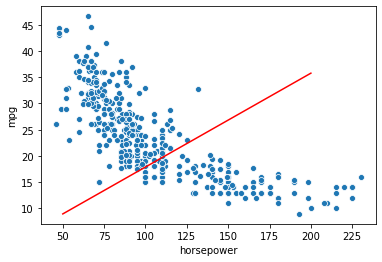

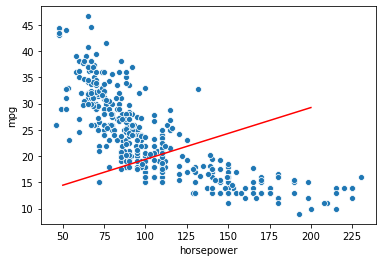

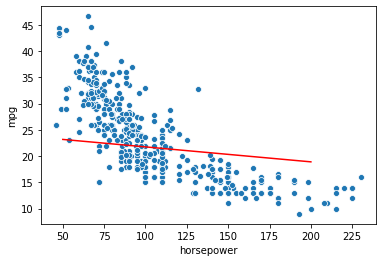

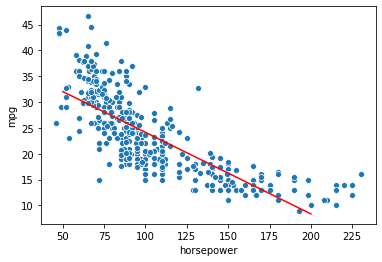

In [123]:
history = np.array([[0.00189195,0.17882795],
                   [9.52606793,0.09853215],
                   [24.58980529,-0.02846621],
                   [39.93586102,-0.15784473]])

for b, a in history:
    xs = np.array([50,200])
    ys = a * xs + b
    sns.scatterplot('horsepower','mpg',data=mpg)
    plt.plot(xs, ys, c='r')
    plt.show()

The last plot is best fit linear model for these two variables.

**Stochastic GD**

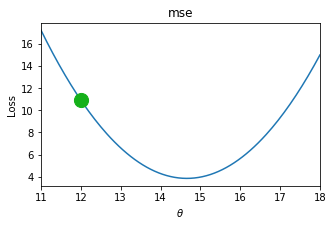

In [124]:
start = 12
plot_loss(pts, (11, 18), mse)
plot_theta_on_loss(pts, start, mse)

In [126]:
def grad_mse_one(pt, theta):#ONLY A SINGLE POINT
    return -2 * (pt - theta)

In [127]:
def plot_sgd_epoch(y_vals, theta, loss_fn, grad_one, alpha=0.3):
    shuffled = np.random.choice(y_vals, size=len(y_vals), replace=False)
    for pt in shuffled:
        new_theta = theta - alpha * grad_one(pt, theta)
        plot_loss(pts, (11, 18), loss_fn)
        plot_theta_on_loss(pts, theta, loss_fn, c='none',
                           edgecolor=sns.xkcd_rgb['green'], linewidth=2)
        plot_theta_on_loss(pts, new_theta, loss_fn)
        theta = new_theta
        plt.show()

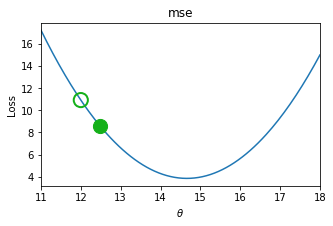

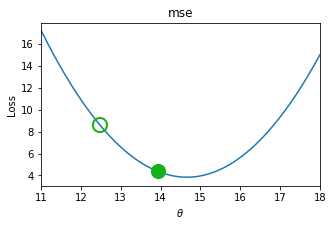

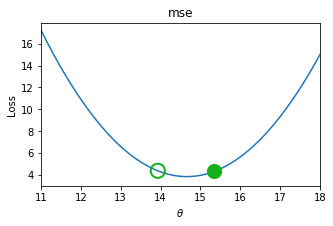

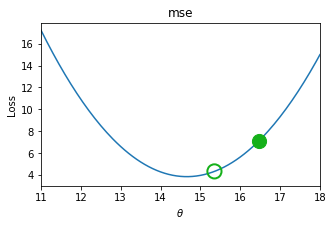

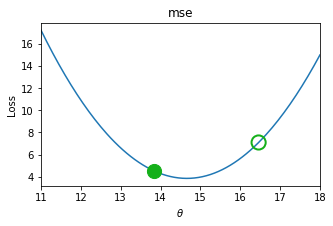

In [128]:
np.random.seed(100)
plot_sgd_epoch(pts, start, mse, grad_mse_one)

## GD Considerations

In [356]:
def mae(pts, theta):
    return np.mean(np.abs(pts - theta))

In [357]:
def grad_mae(pts, theta):
    return np.mean(np.sign(pts - theta))

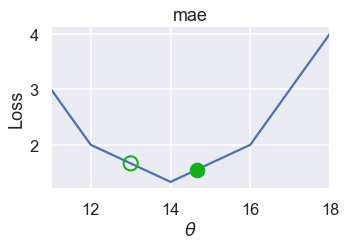

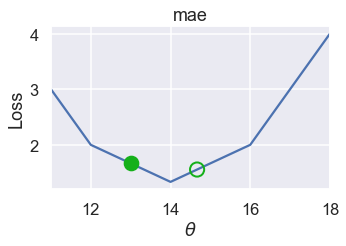

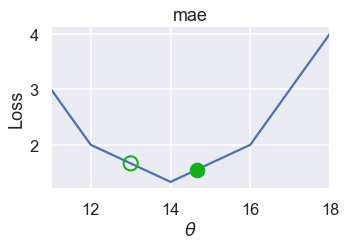

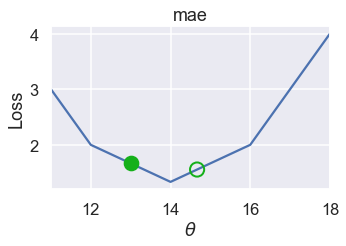

In [364]:
pts = np.array([12, 14, 16])
start = 13
alpha = 5
plot_n_gd_iter(4, pts, start, mae, grad_mae, alpha)